# Learning classifacation using MNIST dataset.

# 1. Importing Libraries

In [1]:
# import libraries.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.base import clone
from sklearn.base import BaseEstimator

from sklearn.model_selection import StratifiedKFold




# 2. Dataset

In [2]:
# loading the dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'].to_numpy(), mnist['target']
X.shape, y.shape



((70000, 784), (70000,))

There are 70,000 images in the dataset, and each image has 784 features (28 X 28 pixels).

Each feature represents each pixels intensity (value between 0 and 255).

Plotting the first image (picking the images feature vector, reshaping it to 28 X 28 array) and displaying it usinng Matplotlibs imshow() function

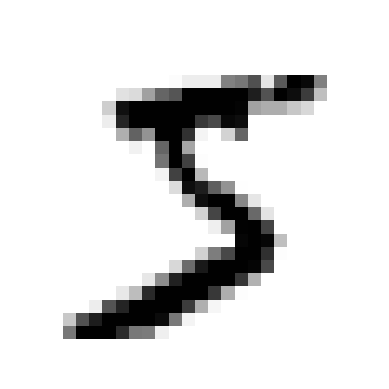

The value of the printed image is  5


In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print("The value of the printed image is ", y[0])

## Cast the target column into integers

In [5]:
# print(type(y[0])) # <class 'str'>

y = y.astype(np.uint8)

# 3. Create train and test set.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 4. Train a Binary Classifier
The first part will be a simple classifier to identify a single digit (lets say 5.) Distinguishes two classes (*binary_classifier*) of *5* and *not 5*

In [7]:
y_train_5 = (y_train == 5) # True for all 5's, False for all other digits.
y_test_5 = (y_test == 5)

## (i) Training using SGDClassifier

In [8]:
sgd = SGDClassifier(random_state= 42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
## test the classifier on the 'some_digit' variable.
sgd.predict([some_digit])

array([ True])

## (ii) Perfomance Measures

### (a) Using Cross Validation

In [10]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
# cross validation using cross_val_score method.
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# creating a dumb classifier that classifies the data as 'not 5' every time.

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.91125, 0.90855, 0.90915])

The accuracy is 90% because only about 10% of the dataset is made of 5's . This makes accuracy not a so good metric for classification purposes.

#### Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual classes')

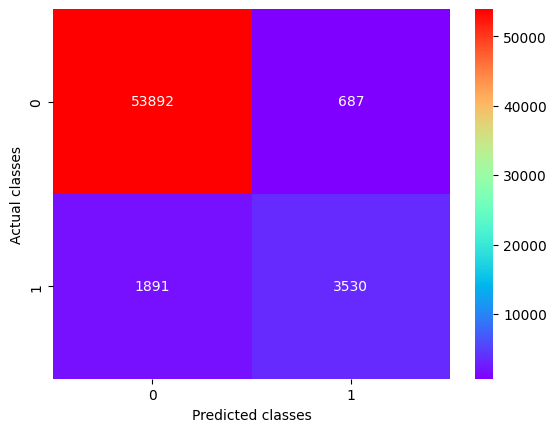

In [13]:
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

cf_matrix = confusion_matrix(y_train_5, y_train_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='rainbow')
plt.xlabel("Predicted classes")
plt.ylabel("Actual classes")

Text(50.722222222222214, 0.5, 'Actual Values')

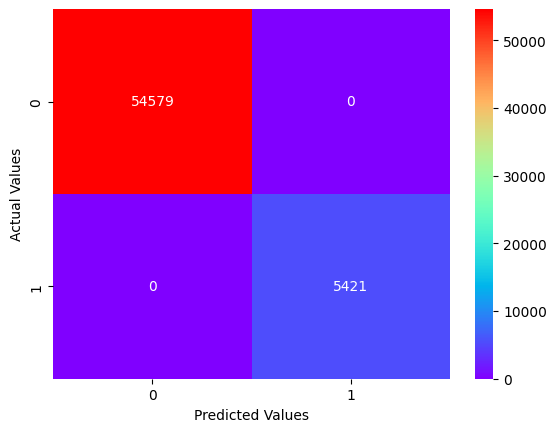

In [14]:
# simulate what a perfect model would look like.
y_train_perfect_predictions = y_train_5
cf_matrix = confusion_matrix(y_train_5, y_train_perfect_predictions)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='rainbow')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

Precision: accuracy of positive predictions. (it is correct n% of times when it claims a prediction belongs to positive class (5-class))

Recall: Ratio of positive instances that are correctly detected by the classifier (it detects n% of the positive class (5s))

#### Precision and Recall



In [15]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

When the model predicts that an image is a five,it is correct 83.71% of the time.

The model only detects 65.12% of 5's in the dataset.

#### Precision Recall Tradeoff.

- Increasing precision reduces recall, and vice versa.

- Precision can be increased by raising the threshold, using the *decision_function()* method instead of the *predict method()*.
- By default, the threshold is set to 0.

In [16]:
# displaying the threshold value.
y_score = sgd.decision_function([some_digit])
y_score

array([2164.22030239])

In [17]:
# default threshold
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [18]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

* Raising the threshold reduces the recall. 

##### Using the dataset.

1. Calculate the scores for all instances in the train dataset using the *cross_val_predict()* method with accuracy set to *decision_function*.
2. Use the scores to compute precision and recall for each possible threshold using the *precision_recall_curve()* method to decide the most appropriate *threshold*.

In [19]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, method='decision_function', cv=3)

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)



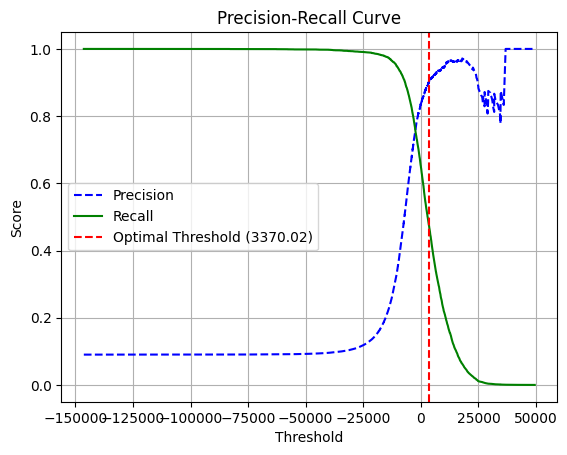

In [20]:
# Plot the  precision and recall functions of the threshold.as_integer_ratio
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    # optimal_threshold = thresholds[precisions.argmax()] 
    optimal_threshold = thresholds[np.argmax(precisions >= 0.90 )] # when a desired precision is known.
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
    
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()


In [21]:
y_pred_100 = (y_scores >= 3370.02)

In [25]:
print("Accuracy: ", accuracy_score(y_train_5, y_pred_100))
precision_score(y_train_5, y_pred_100), recall_score(y_train_5, y_pred_100)

Accuracy:  0.9481833333333334


(0.9, 0.47980077476480354)

<Axes: >

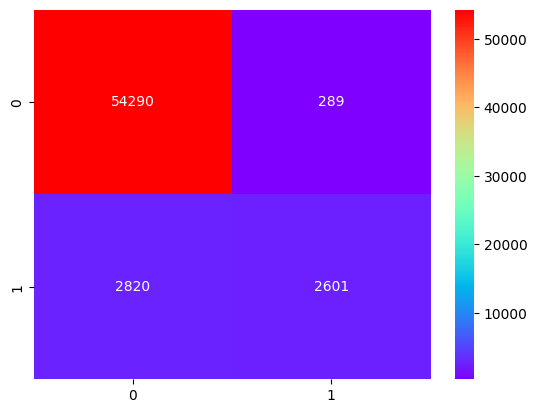

In [23]:
# confusion matrix
cf_matrix = confusion_matrix(y_train_5, y_pred_100)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='rainbow')